In [305]:
import numpy as np
import time
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LinearRegression
from tqdm.notebook import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import torch
import torch.nn as nn
import nltk
import string
from wordcloud import WordCloud 
import re
import seaborn as sns
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [304]:
!pip install kaggle
!pip install contractions
!pip install transformers
import contractions
from transformers import BertForSequenceClassification

     |████████████████████████████████| 2.5MB 2.1MB/s 
     |████████████████████████████████| 3.3MB 10.9MB/s 
     |████████████████████████████████| 901kB 22.3MB/s 


In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"adelante4","key":"03ce7ef6b6693eea773f084c9340b5b9"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c nlp-getting-started

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)


## EDA

In [7]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [9]:
null_counts = pd.DataFrame({"Num_Null": df.isnull().sum()})
null_counts["Pct_Null"] = null_counts["Num_Null"] / df.count() * 100
null_counts

,Num_Null,Pct_Null
id,0,0.000000
keyword,61,0.807733
location,2533,49.862205
text,0,0.000000
target,0,0.000000


### Top keywords

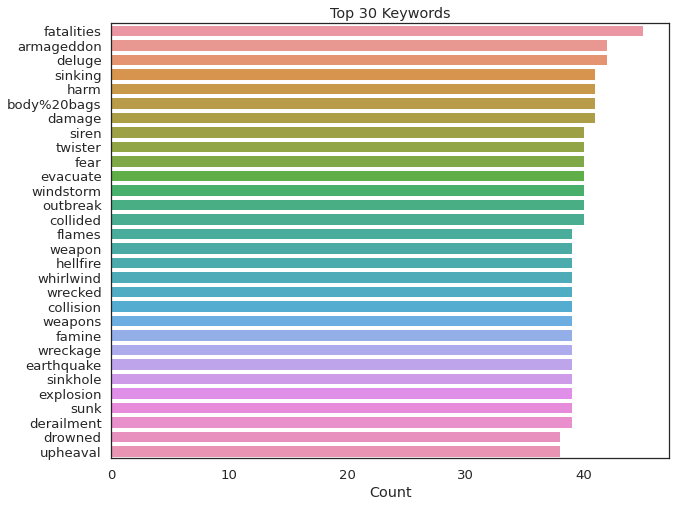

In [10]:
sns.set(style="white", font_scale=1.2)
plt.rcParams["figure.figsize"] = [10,8]

keywords_vc = pd.DataFrame({"Count": df["keyword"].value_counts()})
sns.barplot(y=keywords_vc[0:30].index, x=keywords_vc[0:30]["Count"], orient='h')
plt.title("Top 30 Keywords")
plt.show()

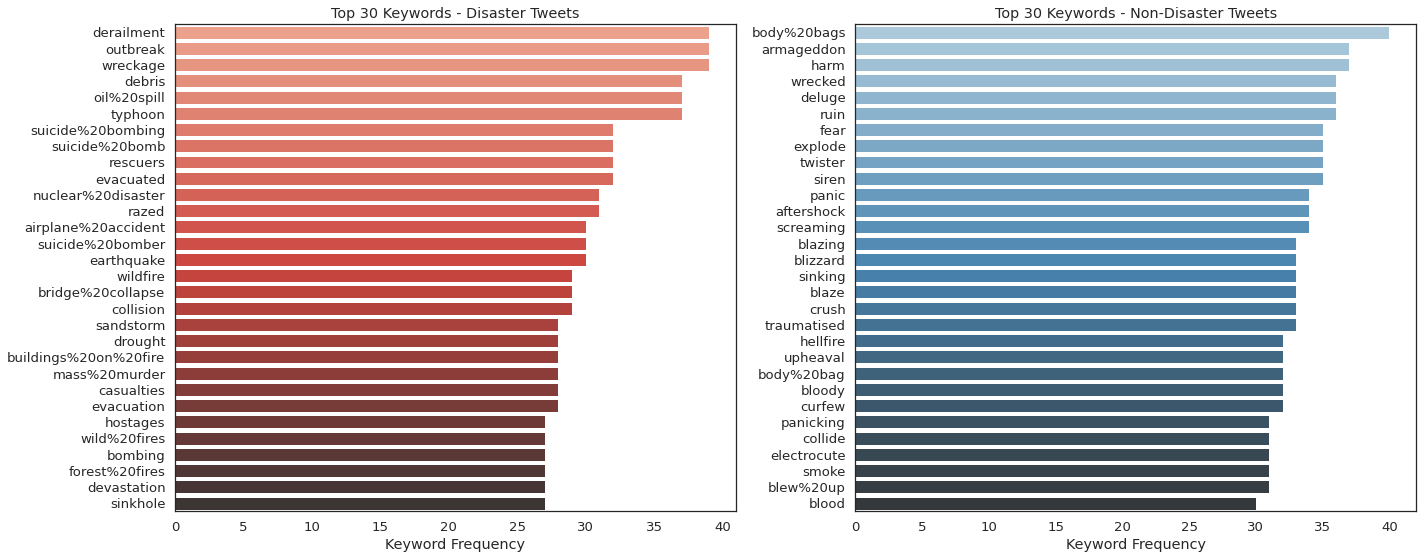

In [11]:
disaster_keywords = df.loc[df["target"] == 1]["keyword"].value_counts()
nondisaster_keywords = df.loc[df["target"] == 0]["keyword"].value_counts()

fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(y=disaster_keywords[0:30].index, x=disaster_keywords[0:30], orient='h', ax=ax[0], palette="Reds_d")
sns.barplot(y=nondisaster_keywords[0:30].index, x=nondisaster_keywords[0:30], orient='h', ax=ax[1], palette="Blues_d")
ax[0].set_title("Top 30 Keywords - Disaster Tweets")
ax[0].set_xlabel("Keyword Frequency")
ax[1].set_title("Top 30 Keywords - Non-Disaster Tweets")
ax[1].set_xlabel("Keyword Frequency")
plt.tight_layout()
plt.show()

### Character counts

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


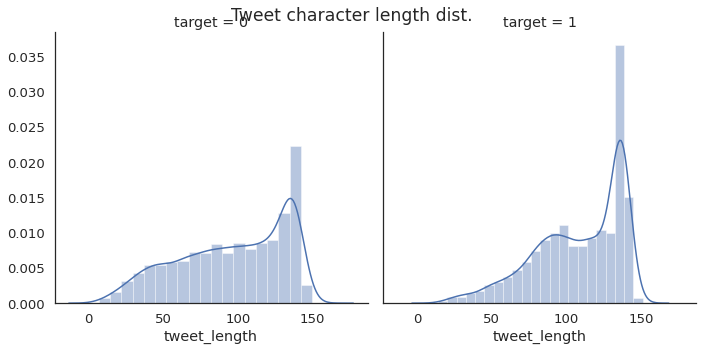

In [12]:
df["tweet_length"] = df["text"].apply(len)
g = sns.FacetGrid(df, col="target", height=5)
g = g.map(sns.distplot, "tweet_length")
plt.suptitle("Tweet character length dist.")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


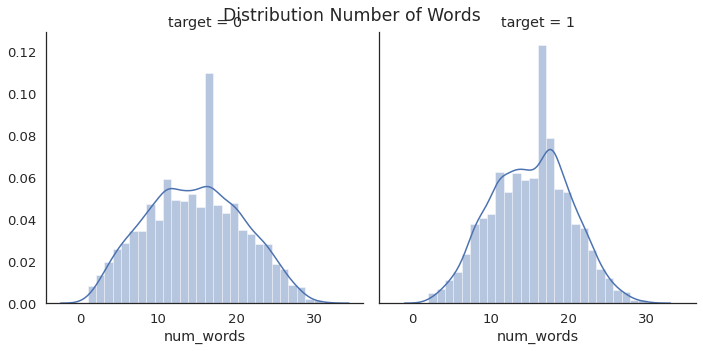

In [13]:
def count_words(x):
    return len(x.split())

df["num_words"] = df["text"].apply(count_words)
g = sns.FacetGrid(df, col="target", height=5)
g = g.map(sns.distplot, "num_words")
plt.suptitle("Distribution Number of Words")
plt.show()

### Target distribution

Not Disaster: 57.03%, Disaster: 42.97%


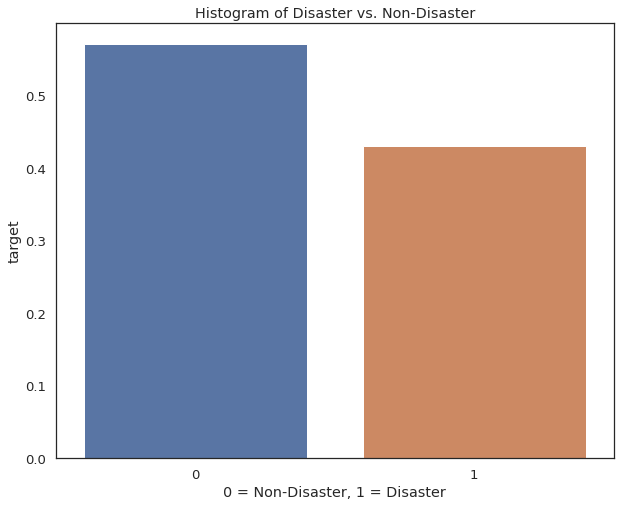

In [14]:
target_vc = df["target"].value_counts(normalize=True)
print("Not Disaster: {:.2%}, Disaster: {:.2%}".format(target_vc[0], target_vc[1]))
sns.barplot(x=target_vc.index, y=target_vc)
plt.title("Histogram of Disaster vs. Non-Disaster")
plt.xlabel("0 = Non-Disaster, 1 = Disaster")
plt.show()

## Text cleaning

### Lowercase

In [15]:
df["text_clean"] = df["text"].apply(lambda x: x.lower())
df_test["text_clean"] = df_test["text"].apply(lambda x: x.lower())

### Remove non-text chars and replace abbrevations

In [16]:
df["text_clean"] = df["text_clean"].apply(lambda x: contractions.fix(x))
df_test["text_clean"] = df_test["text_clean"].apply(lambda x: contractions.fix(x))

In [17]:
def remove_URL(text):
    return re.sub(r"https?://\S+|www\.\S+", "", text)
def remove_html(text):
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", text)
def remove_non_ascii(text):
    return re.sub(r'[^\x00-\x7f]',r'', text)
def remove_special_characters(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
def remove_punct(text):
    return text.translate(str.maketrans('', '', string.punctuation))
def other_clean(text):
        # Typos, slang and other
        sample_typos_slang = {
                                "w/e": "whatever",
                                "usagov": "usa government",
                                "recentlu": "recently",
                                "ph0tos": "photos",
                                "amirite": "am i right",
                                "exp0sed": "exposed",
                                "<3": "love",
                                "luv": "love",
                                "amageddon": "armageddon",
                                "trfc": "traffic",
                                "16yr": "16 year"
                                }

        # Acronyms
        sample_acronyms =  { 
                            "mh370": "malaysia airlines flight 370",
                            "okwx": "oklahoma city weather",
                            "arwx": "arkansas weather",    
                            "gawx": "georgia weather",  
                            "scwx": "south carolina weather",  
                            "cawx": "california weather",
                            "tnwx": "tennessee weather",
                            "azwx": "arizona weather",  
                            "alwx": "alabama weather",
                            "usnwsgov": "united states national weather service",
                            "2mw": "tomorrow"
                            }

        
        # Some common abbreviations 
        sample_abbr = {
                        "$" : " dollar ",
                        "€" : " euro ",
                        "4ao" : "for adults only",
                        "a.m" : "before midday",
                        "a3" : "anytime anywhere anyplace",
                        "aamof" : "as a matter of fact",
                        "acct" : "account",
                        "adih" : "another day in hell",
                        "afaic" : "as far as i am concerned",
                        "afaict" : "as far as i can tell",
                        "afaik" : "as far as i know",
                        "afair" : "as far as i remember",
                        "afk" : "away from keyboard",
                        "app" : "application",
                        "approx" : "approximately",
                        "apps" : "applications",
                        "asap" : "as soon as possible",
                        "asl" : "age, sex, location",
                        "atk" : "at the keyboard",
                        "ave." : "avenue",
                        "aymm" : "are you my mother",
                        "ayor" : "at your own risk", 
                        "b&b" : "bed and breakfast",
                        "b+b" : "bed and breakfast",
                        "b.c" : "before christ",
                        "b2b" : "business to business",
                        "b2c" : "business to customer",
                        "b4" : "before",
                        "b4n" : "bye for now",
                        "b@u" : "back at you",
                        "bae" : "before anyone else",
                        "bak" : "back at keyboard",
                        "bbbg" : "bye bye be good",
                        "bbc" : "british broadcasting corporation",
                        "bbias" : "be back in a second",
                        "bbl" : "be back later",
                        "bbs" : "be back soon",
                        "be4" : "before",
                        "bfn" : "bye for now",
                        "blvd" : "boulevard",
                        "bout" : "about",
                        "brb" : "be right back",
                        "bros" : "brothers",
                        "brt" : "be right there",
                        "bsaaw" : "big smile and a wink",
                        "btw" : "by the way",
                        "bwl" : "bursting with laughter",
                        "c/o" : "care of",
                        "cet" : "central european time",
                        "cf" : "compare",
                        "cia" : "central intelligence agency",
                        "csl" : "can not stop laughing",
                        "cu" : "see you",
                        "cul8r" : "see you later",
                        "cv" : "curriculum vitae",
                        "cwot" : "complete waste of time",
                        "cya" : "see you",
                        "cyt" : "see you tomorrow",
                        "dae" : "does anyone else",
                        "dbmib" : "do not bother me i am busy",
                        "diy" : "do it yourself",
                        "dm" : "direct message",
                        "dwh" : "during work hours",
                        "e123" : "easy as one two three",
                        "eet" : "eastern european time",
                        "eg" : "example",
                        "embm" : "early morning business meeting",
                        "encl" : "enclosed",
                        "encl." : "enclosed",
                        "etc" : "and so on",
                        "faq" : "frequently asked questions",
                        "fawc" : "for anyone who cares",
                        "fb" : "facebook",
                        "fc" : "fingers crossed",
                        "fig" : "figure",
                        "fimh" : "forever in my heart", 
                        "ft." : "feet",
                        "ft" : "featuring",
                        "ftl" : "for the loss",
                        "ftw" : "for the win",
                        "fwiw" : "for what it is worth",
                        "fyi" : "for your information",
                        "g9" : "genius",
                        "gahoy" : "get a hold of yourself",
                        "gal" : "get a life",
                        "gcse" : "general certificate of secondary education",
                        "gfn" : "gone for now",
                        "gg" : "good game",
                        "gl" : "good luck",
                        "glhf" : "good luck have fun",
                        "gmt" : "greenwich mean time",
                        "gmta" : "great minds think alike",
                        "gn" : "good night",
                        "g.o.a.t" : "greatest of all time",
                        "goat" : "greatest of all time",
                        "goi" : "get over it",
                        "gps" : "global positioning system",
                        "gr8" : "great",
                        "gratz" : "congratulations",
                        "gyal" : "girl",
                        "h&c" : "hot and cold",
                        "hp" : "horsepower",
                        "hr" : "hour",
                        "hrh" : "his royal highness",
                        "ht" : "height",
                        "ibrb" : "i will be right back",
                        "ic" : "i see",
                        "icq" : "i seek you",
                        "icymi" : "in case you missed it",
                        "idc" : "i do not care",
                        "idgadf" : "i do not give a damn fuck",
                        "idgaf" : "i do not give a fuck",
                        "idk" : "i do not know",
                        "ie" : "that is",
                        "i.e" : "that is",
                        "ifyp" : "i feel your pain",
                        "IG" : "instagram",
                        "iirc" : "if i remember correctly",
                        "ilu" : "i love you",
                        "ily" : "i love you",
                        "imho" : "in my humble opinion",
                        "imo" : "in my opinion",
                        "imu" : "i miss you",
                        "iow" : "in other words",
                        "irl" : "in real life",
                        "j4f" : "just for fun",
                        "jic" : "just in case",
                        "jk" : "just kidding",
                        "jsyk" : "just so you know",
                        "l8r" : "later",
                        "lb" : "pound",
                        "lbs" : "pounds",
                        "ldr" : "long distance relationship",
                        "lmao" : "laugh my ass off",
                        "lmfao" : "laugh my fucking ass off",
                        "lol" : "laughing out loud",
                        "ltd" : "limited",
                        "ltns" : "long time no see",
                        "m8" : "mate",
                        "mf" : "motherfucker",
                        "mfs" : "motherfuckers",
                        "mfw" : "my face when",
                        "mofo" : "motherfucker",
                        "mph" : "miles per hour",
                        "mr" : "mister",
                        "mrw" : "my reaction when",
                        "ms" : "miss",
                        "mte" : "my thoughts exactly",
                        "nagi" : "not a good idea",
                        "nbc" : "national broadcasting company",
                        "nbd" : "not big deal",
                        "nfs" : "not for sale",
                        "ngl" : "not going to lie",
                        "nhs" : "national health service",
                        "nrn" : "no reply necessary",
                        "nsfl" : "not safe for life",
                        "nsfw" : "not safe for work",
                        "nth" : "nice to have",
                        "nvr" : "never",
                        "nyc" : "new york city",
                        "oc" : "original content",
                        "og" : "original",
                        "ohp" : "overhead projector",
                        "oic" : "oh i see",
                        "omdb" : "over my dead body",
                        "omg" : "oh my god",
                        "omw" : "on my way",
                        "p.a" : "per annum",
                        "p.m" : "after midday",
                        "pm" : "prime minister",
                        "poc" : "people of color",
                        "pov" : "point of view",
                        "pp" : "pages",
                        "ppl" : "people",
                        "prw" : "parents are watching",
                        "ps" : "postscript",
                        "pt" : "point",
                        "ptb" : "please text back",
                        "pto" : "please turn over",
                        "qpsa" : "what happens", #"que pasa",
                        "ratchet" : "rude",
                        "rbtl" : "read between the lines",
                        "rlrt" : "real life retweet", 
                        "rofl" : "rolling on the floor laughing",
                        "roflol" : "rolling on the floor laughing out loud",
                        "rotflmao" : "rolling on the floor laughing my ass off",
                        "rt" : "retweet",
                        "ruok" : "are you ok",
                        "sfw" : "safe for work",
                        "sk8" : "skate",
                        "smh" : "shake my head",
                        "sq" : "square",
                        "srsly" : "seriously", 
                        "ssdd" : "same stuff different day",
                        "tbh" : "to be honest",
                        "tbs" : "tablespooful",
                        "tbsp" : "tablespooful",
                        "tfw" : "that feeling when",
                        "thks" : "thank you",
                        "tho" : "though",
                        "thx" : "thank you",
                        "tia" : "thanks in advance",
                        "til" : "today i learned",
                        "tl;dr" : "too long i did not read",
                        "tldr" : "too long i did not read",
                        "tmb" : "tweet me back",
                        "tntl" : "trying not to laugh",
                        "ttyl" : "talk to you later",
                        "u" : "you",
                        "u2" : "you too",
                        "u4e" : "yours for ever",
                        "utc" : "coordinated universal time",
                        "w/" : "with",
                        "w/o" : "without",
                        "w8" : "wait",
                        "wassup" : "what is up",
                        "wb" : "welcome back",
                        "wtf" : "what the fuck",
                        "wtg" : "way to go",
                        "wtpa" : "where the party at",
                        "wuf" : "where are you from",
                        "wuzup" : "what is up",
                        "wywh" : "wish you were here",
                        "yd" : "yard",
                        "ygtr" : "you got that right",
                        "ynk" : "you never know",
                        "zzz" : "sleeping bored and tired"
                        }
            
        sample_typos_slang_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_typos_slang.keys()) + r')(?!\w)')
        sample_acronyms_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_acronyms.keys()) + r')(?!\w)')
        sample_abbr_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_abbr.keys()) + r')(?!\w)')
        
        text = sample_typos_slang_pattern.sub(lambda x: sample_typos_slang[x.group()], text)
        text = sample_acronyms_pattern.sub(lambda x: sample_acronyms[x.group()], text)
        text = sample_abbr_pattern.sub(lambda x: sample_abbr[x.group()], text)
        
        return text

In [18]:
df["text_clean"] = df["text_clean"].apply(remove_URL)
df["text_clean"] = df["text_clean"].apply(remove_html)
df["text_clean"] = df["text_clean"].apply(remove_non_ascii)
df["text_clean"] = df["text_clean"].apply(remove_special_characters)
df["text_clean"] = df["text_clean"].apply(remove_punct)
df["text_clean"] = df["text_clean"].apply(other_clean)

df_test["text_clean"] = df_test["text_clean"].apply(remove_URL)
df_test["text_clean"] = df_test["text_clean"].apply(remove_html)
df_test["text_clean"] = df_test["text_clean"].apply(remove_non_ascii)
df_test["text_clean"] = df_test["text_clean"].apply(remove_special_characters)
df_test["text_clean"] = df_test["text_clean"].apply(remove_punct)
df_test["text_clean"] = df_test["text_clean"].apply(other_clean)

In [19]:
df[['text', 'text_clean']]

,text,text_clean
0,Our Deeds are the Reason of this #earthquake M...,our deeds are the reason of this earthquake ma...
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,all residents asked to shelter in place are be...
3,"13,000 people receive #wildfires evacuation or...",13000 people receive wildfires evacuation orde...
4,Just got sent this photo from Ruby #Alaska as ...,just got sent this photo from ruby alaska as s...
...,...,...
7608,Two giant cranes holding a bridge collapse int...,two giant cranes holding a bridge collapse int...
7609,@aria_ahrary @TheTawniest The out of control w...,ariaahrary thetawniest the out of control wild...
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,m194 0104 utc5km s of volcano hawaii
7611,Police investigating after an e-bike collided ...,police investigating after an ebike collided w...


### Tokenization

In [20]:
df['tokenized'] = df['text_clean'].apply(word_tokenize)
df_test['tokenized'] = df_test['text_clean'].apply(word_tokenize)

### Stopword removal

In [21]:
stop = set(stopwords.words('english'))
df['stopwords_removed'] = df['tokenized'].apply(lambda x: [word for word in x if word not in stop])
df_test['stopwords_removed'] = df_test['tokenized'].apply(lambda x: [word for word in x if word not in stop])

In [22]:
df[['text', 'stopwords_removed']]

,text,stopwords_removed
0,Our Deeds are the Reason of this #earthquake M...,"[deeds, reason, earthquake, may, allah, forgiv..."
1,Forest fire near La Ronge Sask. Canada,"[forest, fire, near, la, ronge, sask, canada]"
2,All residents asked to 'shelter in place' are ...,"[residents, asked, shelter, place, notified, o..."
3,"13,000 people receive #wildfires evacuation or...","[13000, people, receive, wildfires, evacuation..."
4,Just got sent this photo from Ruby #Alaska as ...,"[got, sent, photo, ruby, alaska, smoke, wildfi..."
...,...,...
7608,Two giant cranes holding a bridge collapse int...,"[two, giant, cranes, holding, bridge, collapse..."
7609,@aria_ahrary @TheTawniest The out of control w...,"[ariaahrary, thetawniest, control, wild, fires..."
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,"[m194, 0104, utc5km, volcano, hawaii]"
7611,Police investigating after an e-bike collided ...,"[police, investigating, ebike, collided, car, ..."


### Stemming

In [23]:
def snowball_stemmer(text):
    stemmer = nltk.SnowballStemmer("english")
    stems = [stemmer.stem(i) for i in text]
    return stems

In [24]:
df['text_clean'] = df['stopwords_removed'].apply(lambda x: snowball_stemmer(x))
df_test['text_clean'] = df_test['stopwords_removed'].apply(lambda x: snowball_stemmer(x))

In [25]:
df[['text_clean', 'stopwords_removed']]

,text_clean,stopwords_removed
0,"[deed, reason, earthquak, may, allah, forgiv, us]","[deeds, reason, earthquake, may, allah, forgiv..."
1,"[forest, fire, near, la, rong, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"
2,"[resid, ask, shelter, place, notifi, offic, ev...","[residents, asked, shelter, place, notified, o..."
3,"[13000, peopl, receiv, wildfir, evacu, order, ...","[13000, people, receive, wildfires, evacuation..."
4,"[got, sent, photo, rubi, alaska, smoke, wildfi...","[got, sent, photo, ruby, alaska, smoke, wildfi..."
...,...,...
7608,"[two, giant, crane, hold, bridg, collaps, near...","[two, giant, cranes, holding, bridge, collapse..."
7609,"[ariaahrari, thetawniest, control, wild, fire,...","[ariaahrary, thetawniest, control, wild, fires..."
7610,"[m194, 0104, utc5km, volcano, hawaii]","[m194, 0104, utc5km, volcano, hawaii]"
7611,"[polic, investig, ebik, collid, car, littl, po...","[police, investigating, ebike, collided, car, ..."


### Lemmatizing

In [26]:
lemmatizer = WordNetLemmatizer()
df['lemmatized'] = df['text_clean'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
df_test['lemmatized'] = df_test['text_clean'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [27]:
df[['lemmatized', 'text_clean']]

,lemmatized,text_clean
0,"[deed, reason, earthquak, may, allah, forgiv, u]","[deed, reason, earthquak, may, allah, forgiv, us]"
1,"[forest, fire, near, la, rong, sask, canada]","[forest, fire, near, la, rong, sask, canada]"
2,"[resid, ask, shelter, place, notifi, offic, ev...","[resid, ask, shelter, place, notifi, offic, ev..."
3,"[13000, peopl, receiv, wildfir, evacu, order, ...","[13000, peopl, receiv, wildfir, evacu, order, ..."
4,"[got, sent, photo, rubi, alaska, smoke, wildfi...","[got, sent, photo, rubi, alaska, smoke, wildfi..."
...,...,...
7608,"[two, giant, crane, hold, bridg, collaps, near...","[two, giant, crane, hold, bridg, collaps, near..."
7609,"[ariaahrari, thetawniest, control, wild, fire,...","[ariaahrari, thetawniest, control, wild, fire,..."
7610,"[m194, 0104, utc5km, volcano, hawaii]","[m194, 0104, utc5km, volcano, hawaii]"
7611,"[polic, investig, ebik, collid, car, littl, po...","[polic, investig, ebik, collid, car, littl, po..."


### Disater words cloud

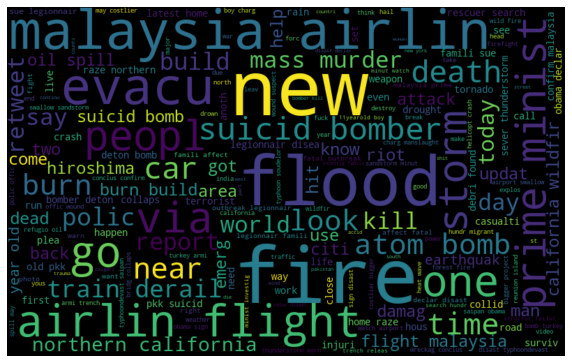

In [28]:
normal_words =' '.join([' '.join(text) for text in df['lemmatized'][df['target'] == 1]]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Word vectors

In [281]:
from gensim.models import Word2Vec
EMB_SIZE = 150

skip_gram_model = Word2Vec(df['text_clean'],size=EMB_SIZE,window=3,min_count=2,sg=0)
skip_gram_model.train(df['text_clean'],total_examples=len(df['text_clean']),epochs=25)

(1516777, 1767775)

In [282]:
skip_gram_model.wv.most_similar('car', topn=10) 

[('xoxo', 0.8200212121009827),
 ('motorcycl', 0.7866523861885071),
 ('disney', 0.7720800638198853),
 ('rail', 0.7695556282997131),
 ('wreck', 0.7671979665756226),
 ('identitytheft', 0.7542692422866821),
 ('hard', 0.7363719940185547),
 ('aquarium', 0.7363387942314148),
 ('cnbc', 0.735724687576294),
 ('lover', 0.7341086864471436)]

In [283]:
df['len'] = df.text_clean.apply(len)
df_test['len'] = df_test.text_clean.apply(len)

In [284]:
df.len.describe()

count    7613.000000
mean        9.288191
std         3.640284
min         1.000000
25%         7.000000
50%         9.000000
75%        12.000000
max        24.000000
Name: len, dtype: float64

In [285]:
UNK_VEC = np.random.randn(EMB_SIZE,)

In [286]:
def build_dataset(text_df, w2v, seq_len=12, test=False):
  X = []
  y = []
  emb_size = w2v.wv['flood'].shape[0]
  for idx, t in tqdm(text_df.iterrows(), total=text_df.shape[0]):
    if len(t['text_clean']) < seq_len:
      sent = []
      for w in t['text_clean']:
        if w in w2v.wv:
          sent.append(w2v.wv[w])
        else:
          sent.append(UNK_VEC)
      ### add padding 
      for i in range(seq_len - len(t['text_clean'])):
        sent.append(np.zeros(emb_size, ))
    else:
      sent = []
      for i in range(seq_len):
        if t['text_clean'][i] in w2v.wv:
          sent.append(w2v.wv[t['text_clean'][i]])
        else:
          sent.append(UNK_VEC)
    if not test:
      y.append(t['target'])
    else:
      y.append(t['id'])
    X.append(np.array(sent))


  return np.array(X), np.array(y).reshape(-1, 1)

In [287]:
X_train, y_train = build_dataset(df[['text_clean', 'target']], skip_gram_model, seq_len=10)
X_test, y_id = build_dataset(df_test[['text_clean', 'id']], skip_gram_model, test=True, seq_len=10)

In [288]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.2)

In [289]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

train_features = torch.Tensor(X_train)
train_targets = torch.Tensor(y_train)
val_features = torch.Tensor(X_val)
val_targets = torch.Tensor(y_val)
test_features = torch.Tensor(X_test)
test_ids = torch.Tensor(y_id)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_ids)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

In [290]:
class LSTMModel(nn.Module):

    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):

        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):

        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = out[:, -1, :]

        out = self.fc(torch.relu(out))
        
        return torch.sigmoid(out)

In [295]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []

    def train_step(self, x, y):
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        # print(y)
        # print(yhat)
        loss = self.loss_fn(yhat, y)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item(), yhat

    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1, n_input=7):
        best_acc = 0
        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:

                x_batch = x_batch.view([batch_size, -1, n_features])#.cuda()
                y_batch = y_batch#.cuda()

                loss, yhat = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)

            train_accuracy = (y_batch == (yhat > 0.5)).sum() / float(len(y_batch))
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features])#.cuda()
                    y_val = y_val#.cuda()


                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(yhat, y_val).item()
                    batch_val_losses.append(val_loss)
                
                val_accuracy = (y_val == (yhat > 0.5)).sum() / float(len(y_val))
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) | (epoch % 5 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Training accuracy: {train_accuracy:.4f} \t Validation loss: {validation_loss:.4f}\t Validation accuracy: {val_accuracy:.4f}"
                )
            if val_accuracy > best_acc:
              torch.save(model.state_dict(), 'best-model-parameters.pt') 
              best_acc = val_accuracy



    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

In [296]:
def evaluate(model, test_loader, batch_size=1, n_features=1):
    with torch.no_grad():
        predictions = []
        values = []
        for xb, xid in test_loader:
            xb = xb[0].view([batch_size, -1, n_features])#.cuda()


            model.eval()
            yhat = model(xb)
            
            predictions.append(int(yhat.cpu().detach().numpy()>0.5))
            values.append(int(xid))

    return predictions, values

[1/75] Training loss: 0.6440	 Training accuracy: 0.7188 	 Validation loss: 0.5664	 Validation accuracy: 0.7500
[2/75] Training loss: 0.5571	 Training accuracy: 0.7344 	 Validation loss: 0.5241	 Validation accuracy: 0.7344
[3/75] Training loss: 0.5261	 Training accuracy: 0.7188 	 Validation loss: 0.5111	 Validation accuracy: 0.7812
[4/75] Training loss: 0.5124	 Training accuracy: 0.7344 	 Validation loss: 0.4987	 Validation accuracy: 0.7812
[5/75] Training loss: 0.5006	 Training accuracy: 0.7656 	 Validation loss: 0.4884	 Validation accuracy: 0.7969
[6/75] Training loss: 0.4906	 Training accuracy: 0.7812 	 Validation loss: 0.4845	 Validation accuracy: 0.8125
[7/75] Training loss: 0.4847	 Training accuracy: 0.7812 	 Validation loss: 0.4784	 Validation accuracy: 0.7969
[8/75] Training loss: 0.4761	 Training accuracy: 0.8125 	 Validation loss: 0.4718	 Validation accuracy: 0.7969
[9/75] Training loss: 0.4707	 Training accuracy: 0.7812 	 Validation loss: 0.4707	 Validation accuracy: 0.8125
[

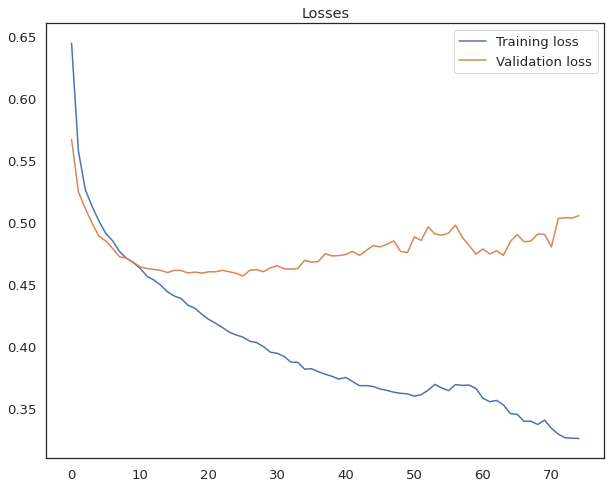

In [299]:
input_dim = EMB_SIZE
output_dim = 1
hidden_dim = 15
layer_dim = 2
batch_size = 64
dropout = 0.2
n_epochs = 75
learning_rate = 1e-3
weight_decay = 1e-6

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim, dropout)

model = model#.cuda()
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

In [300]:
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim, dropout)
model.load_state_dict(torch.load('best-model-parameters.pt'))

<All keys matched successfully>

In [301]:
predictions, ids = evaluate(model, test_loader_one, batch_size=1, n_features=input_dim)

In [302]:
submission = pd.DataFrame(data={'id': ids, 'target': predictions})

In [303]:
submission.to_csv('submission.csv', index=False)